# Формальные модели синаптических проводимостей

**По материалам статей:**

 - Destexhe, Mainen, Sejnowski. Synthesis of Models for Excitable Membranes, Synaptic Transmission and Neuromodulation Using a Common Kinetic Formalism. *Journal of Computational Neuroscience*, **1**, 195–230 (1994)


 - Destexhe, Mainen, Sejnowski. An Efficient Method for Computing Synaptic Conductances Based on a Kinetic Model of Receptor Binding. *Neural Computation* **6**, 14–18 (1994)

In [1]:
#%pylab inline
%matplotlib inline

In [2]:
from matplotlib import pyplot as plt
import matplotlib as mpl

from matplotlib.pyplot import colorbar, close, figure, gca, gcf, imshow, plot, setp, subplots
from matplotlib.pyplot import title, suptitle, ylabel, xlabel, xlim, ylim
from matplotlib.pyplot import legend

import numpy as np
from numpy import linalg


# import most often used functions
from numpy import array, arange, clip, ones, percentile, where, zeros
from numpy import exp, tanh, log

from numpy.linalg import svd
from numpy.random import permutation

In [3]:
#rc('axes',grid=True)
#rc('grid',color=(0.9,)*3,ls=':')

In [4]:
plt.style.use(['ggplot','seaborn-v0_8-muted'])
mpl.rc('figure', figsize=(9,9*0.618), dpi=150)

## Постсинаптические проводимости

In [5]:
def single_exp(t,ts=0,tau=3.):
    return np.exp(-(t-ts)/tau)*(t>=ts)

def alpha_func(t, ts=0, tau=3.):
    return np.e*(t-ts)/tau*np.exp(-(t-ts)/tau)*(t>=ts)

def double_exp_u(t,ts=0,tau1=2,tau2=3.):
    return (t>=ts)*(tau1*tau2/(tau1-tau2))*(np.exp(-(t-ts)/tau1) - np.exp(-(t-ts)/tau2))

def double_exp(t,ts=0,tau_r=2,tau_d=3.):
    tmax = ts + log(tau_d/tau_r)*tau_r*tau_d/(tau_d-tau_r)
    vmax = double_exp_u(tmax,ts,tau_r,tau_d)
    return double_exp_u(t,ts,tau_r,tau_d)/vmax

In [6]:
tx = arange(0,12,0.01)

Text(0.5, 1.0, 'нормированные постсинаптические проводимости')

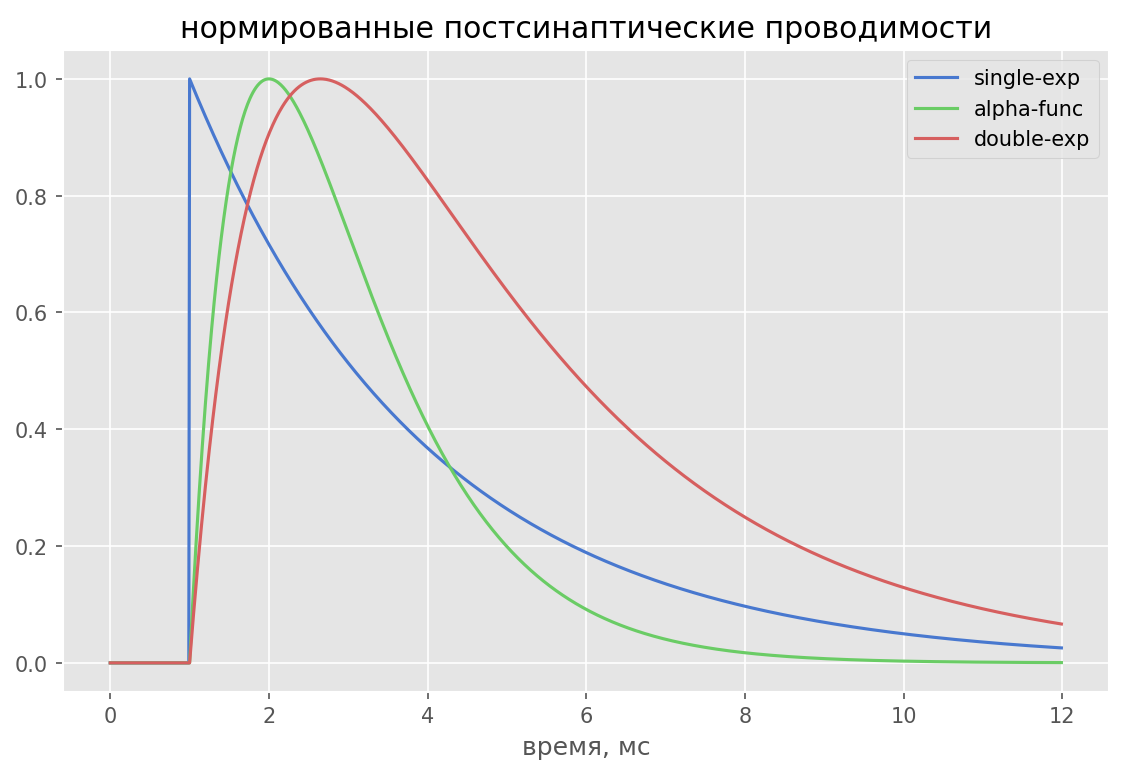

In [7]:
plot(tx,single_exp(tx,1,3),label='single-exp')
plot(tx,alpha_func(tx,1,1),label='alpha-func')
plot(tx,double_exp(tx,1,1,3),label='double-exp')
legend()
xlabel('время, мс')
title('нормированные постсинаптические проводимости')

Text(0.5, 1.0, 'Ответ на серию спайков')

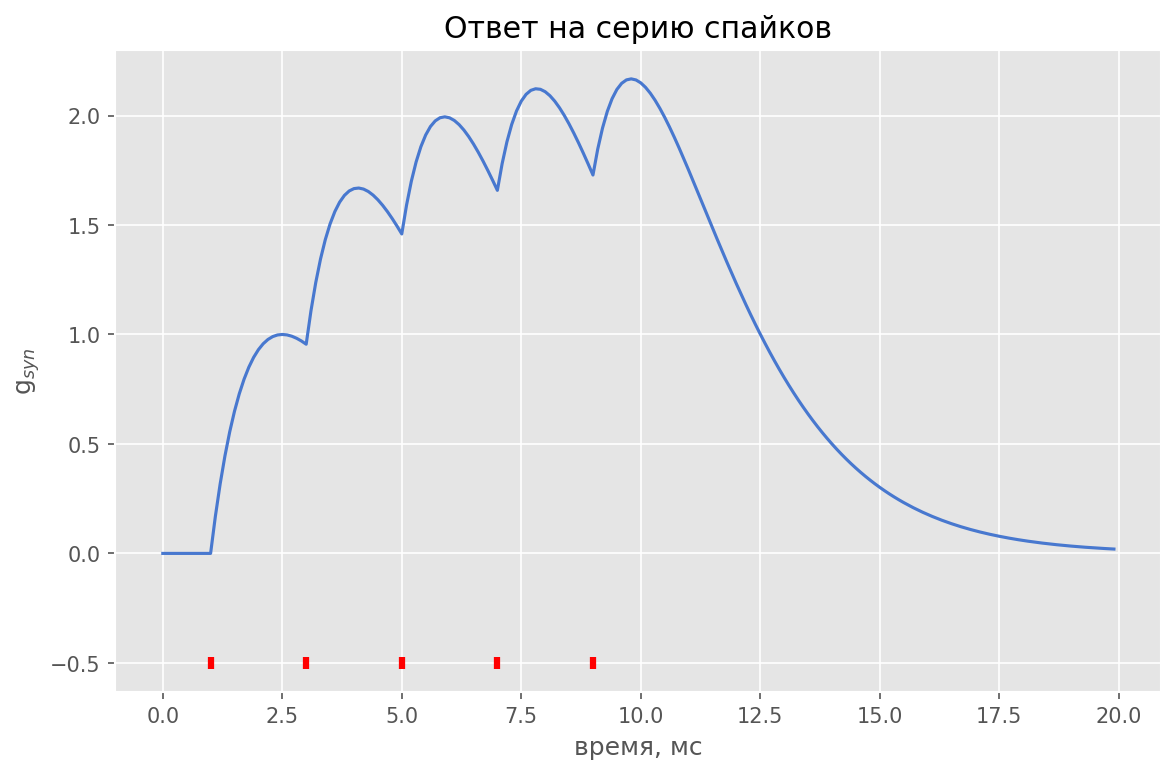

In [8]:
spike_times = arange(1,10,2)

tx = arange(0,20,0.1)
gsyn = sum(alpha_func(tx,ti,1.5) for ti in spike_times)
plot(tx, gsyn)
plot(spike_times,[-0.5]*len(spike_times), 'r|',mew=3)
xlabel('время, мс')
ylabel('g$_{syn}$')
title('Ответ на серию спайков')

Но если использовать такое описание, нужно хранить список недавних спайков...

####  Зависимость от потенциала и концентрации Mg<sup>2+</sup>: NMDA

\begin{equation}
g_\mathrm{NMDA} = 
\bar{g}_{syn}\frac{\exp(-\frac{t-t_s}{\tau_r}) - \exp(-\frac{t-t_s}{\tau_d})}{1 + \mu[\mathrm{Mg}^{2+}]e^{-\gamma V}}
\end{equation}

### Кинетические схемы

#### AMPA рецепторы (простая схема)

$C \overset{r_1}{\underset{r_2}\rightleftarrows} O   \overset{r_3}{\underset{r_4}\rightleftarrows} D$

In [9]:
from scipy.interpolate import UnivariateSpline as usp

def I_pulse(tx, amp, start, stop,k=10):
    return amp*0.5*(1 + tanh(k*(tx-start)) * tanh(k*(-tx+stop)))

def I_ramp(tx, k, start=50,stop=1000):
    #return  k*(tx-start)*I_pulse(tx, 1, start, stop)
    return usp(tx, k*(tx-start)*I_pulse(tx, 1, start, stop),s=0)


def make_pulses(tv, npulses=5, period=5, start=100, amp=5, width=1,steep=10.):
    onsets = arange(start, start+npulses*period,period)
    y = sum(I_pulse(tv, amp, on, on+width,k=steep) for on in onsets)
    return usp(tv, y, s=0)

def combine_interpolations(tv, signals):
    y = sum(s(tv) for s in signals)
    return usp(tv, y, s=0)


In [10]:
class SelfAdvancingODE:
    def advance(self, t, dt):
        fnew = self.rhs(t)
        xnew = self.state + 0.5*dt*(3*fnew - self.fprev)
        self.state = xnew
        self.fprev = fnew
        return xnew    

class AMPAR(SelfAdvancingODE):
    def __init__(self, g_source, gmax=1, r1=0.960,r2=0.190,r3=0.020,r4=0.015,):
        self.state = array((0,0)) # prob(open), prob(desensitized)
        self.fprev = 0
        self.g_source = g_source
        self.rates = [r1,r2,r3,r4]
        self.gmax=gmax
    @property
    def c(self):
        return 1-np.sum(self.state)
    @property
    def g(self):
        return self.gmax*self.state[0]
    def isyn(self,V):
        return self.g*V
    def rhs(self,t):
        # G is glutamate conc. in mM
        c,o,d = self.c, self.state[0],self.state[1]
        G = self.g_source(t)
        r1,r2,r3,r4 = self.rates
        vdesens = r4*d - r3*o
        do = c*r1*G - r2*o  + vdesens
        dd = -vdesens
        return array((do,dd))

Text(0.5, 0, 'время, мс')

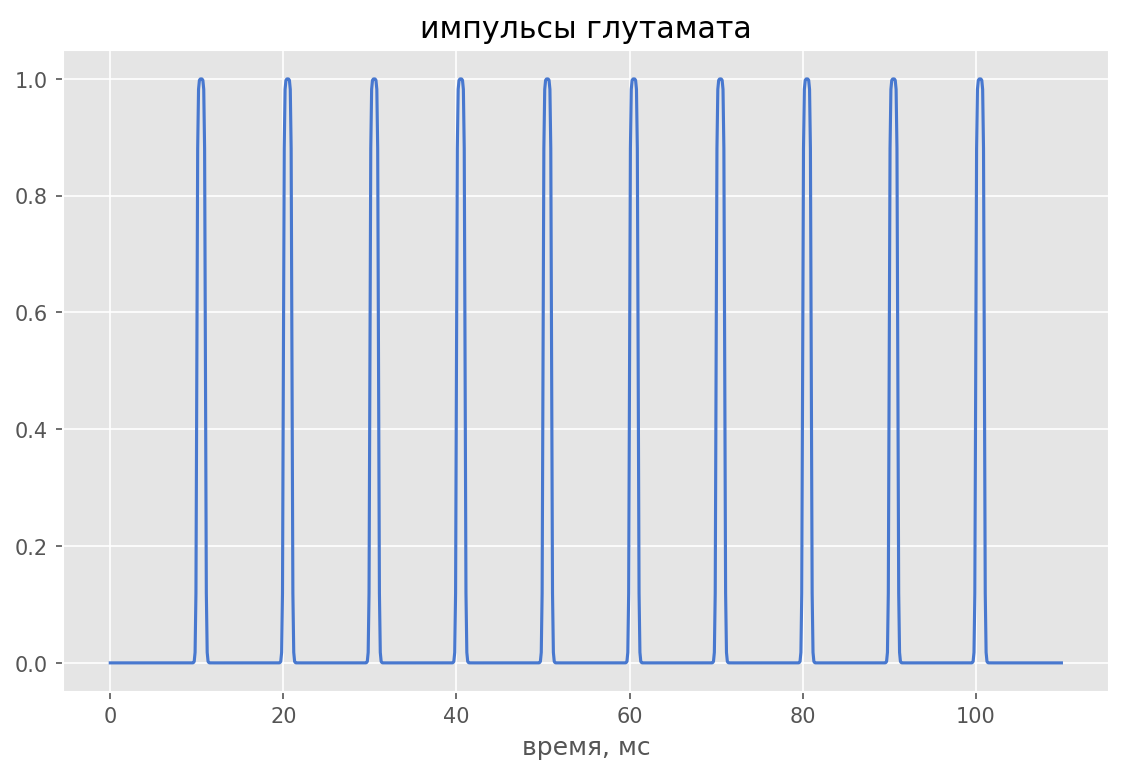

In [11]:
tvx = arange(0,110,0.1)
glu_pulses = make_pulses(tvx, 10, period=10, width=1,start=10, amp=1)
plot(tvx,glu_pulses(tvx))
title('импульсы глутамата')
xlabel('время, мс')

In [12]:
r = AMPAR(glu_pulses)

Vm = -65
h = 0.1

tv = np.arange(0,130,h)
gsyn = np.zeros_like(tv)
isyn = np.zeros_like(tv)

for i,t in enumerate(tv):
    o,d = r.advance(t,h)
    gsyn[i] = r.g
    isyn[i] = r.isyn(Vm)

Text(0.5, 0, 'время, мс')

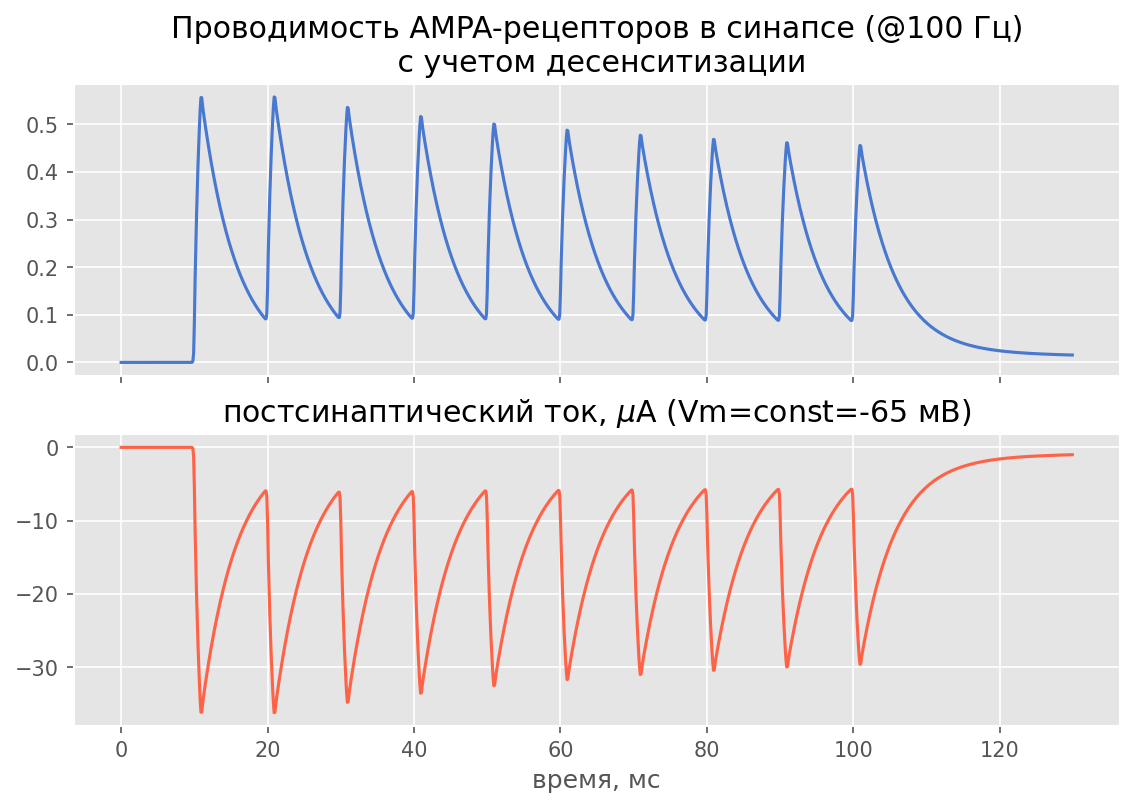

In [13]:
f,axs = subplots(2,1,sharex=True)

axs[0].plot(tv,  gsyn)
axs[0].set_title("Проводимость AMPA-рецепторов в синапсе (@100 Гц)\n с учетом десенситизации")

axs[1].plot(tv,  isyn,color='tomato')
axs[1].set_title("постсинаптический ток, $\mu$A (Vm=const=-65 мВ)")

axs[1].set_xlabel('время, мс')

In [14]:
class NMDAR(SelfAdvancingODE):
    def __init__(self, g_source, gmax=0.1, Mg=1.5,
                 rb=5, ru=13e-3, rd=8.4e-3, 
                 rr=6.8e-3,ro=45.6e-3,rc=73.8e-3):
        self.state = array((0,0,0,0)) # p(open),p(desensetized),p(c2),p(c1)
        self.fprev = 0
        self.g_source = g_source
        self.rates = [rb,ru,rd,rr,ro,rc]
        self.gmax=gmax
        self.Mg=Mg
    @property
    def c0(self):
        return 1-np.sum(self.state)
    @property
    def g(self):
        return self.gmax*self.state[0]
    def vblock(self,V):
        return 1/(1 + exp(-0.062*V)*self.Mg/3.57)
    def isyn(self,V):
        return self.g*self.vblock(V)*V
    def rhs(self,t):
        # G is glutamate conc. in mM
        o,d,c2,c1 = self.state
        c0 = self.c0
        G = self.g_source(t)
        rb,ru,rd,rr,ro,rc = self.rates
        
        vdesens = rr*d - rd*c2
        vopen = ro*c2 - rc*o
        
        do = vopen
        dd = -vdesens    
        dc2 = -vopen + vdesens + rb*G*c1 - ru*c2
        dc1 = rb*G*(c0-c2) - ru*(c1-c2)
        return array((do,dd,dc2,dc1))
        

In [15]:
rn = NMDAR(glu_pulses)

Vm1,Vm2 = -65,-40

tv = arange(0,500,h)

gsyn = np.zeros_like(tv)
isyn1 = np.zeros_like(tv)
isyn2 = np.zeros_like(tv)

for i,t in enumerate(tv):
    rn.advance(t,h)
    gsyn[i] = rn.g
    isyn1[i] = rn.isyn(Vm1)
    isyn2[i] = rn.isyn(Vm2)
    


Text(0.5, 0, 'мембранный потенциал, мВ')

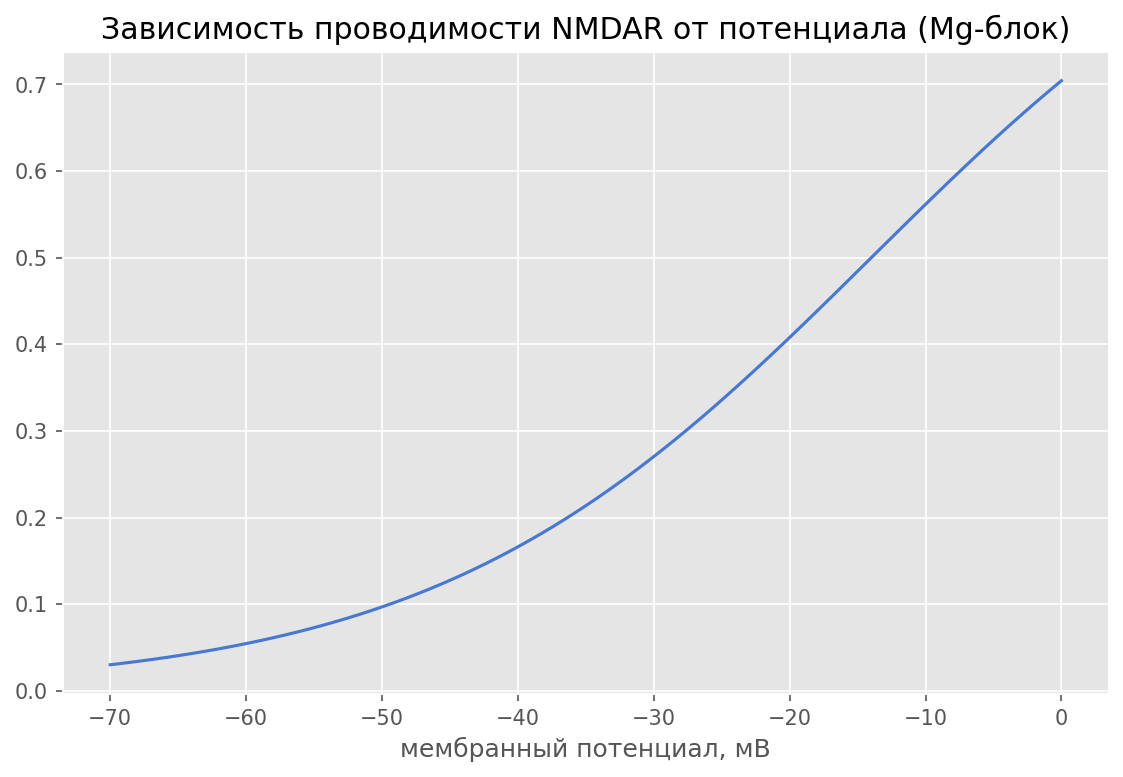

In [16]:
vx = np.linspace(-70,0,100)
plot(vx, rn.vblock(vx))
title('Зависимость проводимости NMDAR от потенциала (Mg-блок)')
xlabel('мембранный потенциал, мВ')

Text(0.5, 0, 'время, мс')

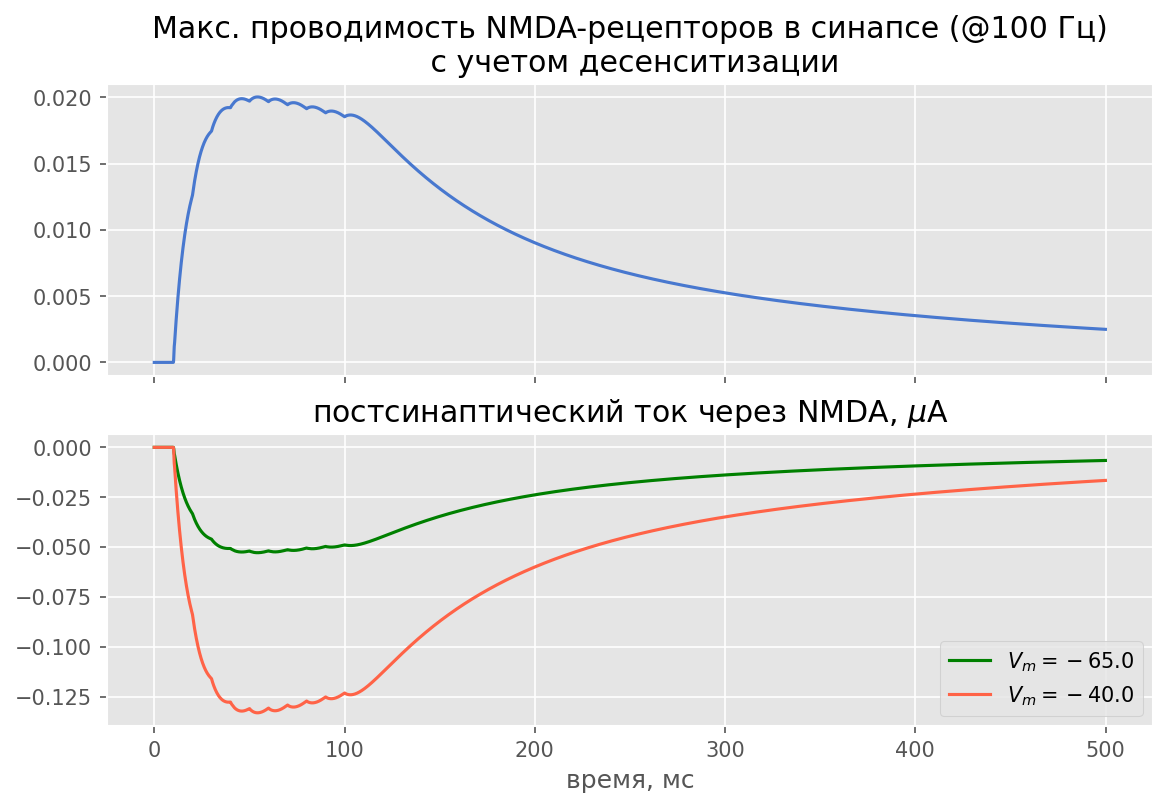

In [17]:
f,axs = subplots(2,1,sharex=True)


axs[0].plot(tv,  gsyn)
axs[0].set_title("Макс. проводимость NMDA-рецепторов в синапсе (@100 Гц)\n с учетом десенситизации")

axs[1].plot(tv,  isyn1,color='green',label='$V_m=%1.1f$'%Vm1)
axs[1].plot(tv,  isyn2,color='tomato',label='$V_m=%1.1f$'%Vm2)
axs[1].set_title("постсинаптический ток через NMDA, $\mu$A")
axs[1].legend()

axs[1].set_xlabel('время, мс')

In [18]:
class GABAAR(AMPAR):
    def __init__(self, g_source, gmax=1, Vrev=-70, r1=0.2300,r2=0.170,r3=0.045,r4=0.067,):
        self.state = array((0,0)) # prob(open), prob(desensetized)
        self.fprev = 0
        self.g_source = g_source
        self.rates = [r1,r2,r3,r4]
        self.gmax=gmax
        self.Vr = Vrev
    def isyn(self,V):
        return self.g*(V-self.Vr)

In [19]:
rg = GABAAR(glu_pulses) # Используем импульсы глутамата вместо GABA

Vm = -65

gsyn = np.zeros_like(tv)
isyn = np.zeros_like(tv)

for i,t in enumerate(tv):
    rg.advance(t,h)
    gsyn[i] = rg.g
    isyn[i] = rg.isyn(Vm)
    
    

Text(0.5, 0, 'время, мс')

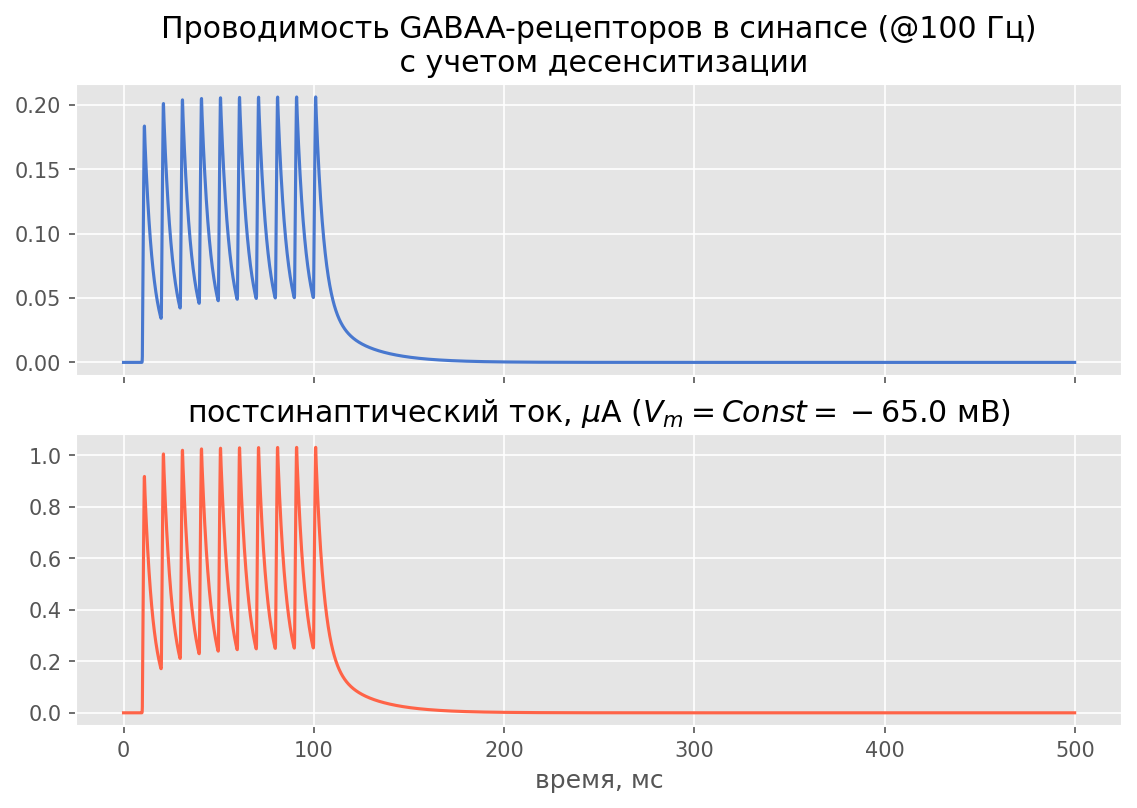

In [20]:
f,axs = subplots(2,1,sharex=True)

axs[0].plot(tv,  gsyn)
axs[0].set_title("Проводимость GABAA-рецепторов в синапсе (@100 Гц)\n с учетом десенситизации")

axs[1].plot(tv,  isyn,color='tomato')
axs[1].set_title("постсинаптический ток, $\mu$A ($V_m=Const= %1.1f$ мВ)"%Vm)

axs[1].set_xlabel('время, мс')

##  Пресинаптическая кратковременная пластичность

In [21]:

# Typical values for
# depressing (pyr->pyr):  f=0, p0=0.5, tau_r = 800
# facilitating (pyr->inter): f = 0.05, tau_r = 300, tau_f = 1500

class TMSynapseDet(SelfAdvancingODE):
    """Tsodyks-Markram determenistic synapse wihth depression and facilitation"""
    def __init__(self,spike_source,f=0.05,tau_r=300, tau_f=1500, p0=0.05):
        self.state = array([1,p0]) # n,p
        self.tau_r = tau_r
        self.tau_f = tau_f
        self.f = f
        self.p0=p0
        self.spikes = spike_source
        self.fprev = 0
    def rhs(self,t):
        n,p = self.state
        is_spike = self.spikes(t)
        
        dp = (self.p0-p)/self.tau_f + is_spike*self.f*(1-p)
        dn = (1-n)/self.tau_r - is_spike*p*n
        return array((dn,dp))
    @property
    def p(self): return self.state[1]
    @property
    def n(self): return self.state[0]

0.0015


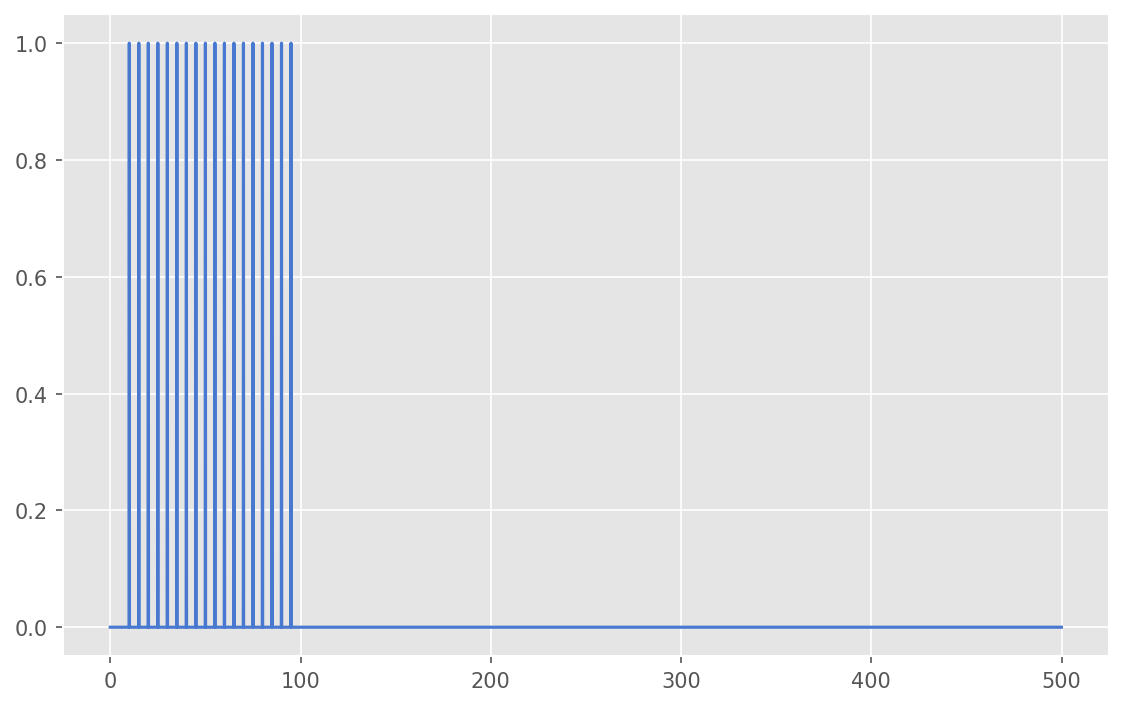

In [22]:
spike_rate = 200 # Hz
ph = 15 * h /1000
print( ph)
#spike_source = array([1 if rand()<ph else 0 for t in tv])
spikes = lambda t,period=5: (t%period == 0)*(t>=10)*(t<100)
plot(tv, spikes(tv))

In [23]:
spikes = lambda t,period=5: (t%period == 0)*(t>=100)*(t<400)
ps_fac = TMSynapseDet(spikes)
ps_dep = TMSynapseDet(spikes, p0=0.5, f=0.0, tau_r=800)
#ps1 = TMSynapseDet(spikes,p0=0.25)

In [24]:
tv = arange(0,1000,h)

trajf = zeros((len(tv),2))
trajd = zeros((len(tv),2))
for i,t in enumerate(tv):
    trajf[i] = ps_fac.advance(t, h)
    trajd[i] = ps_dep.advance(t, h)

Text(0.5, 1.0, 'relative transmitter output ')

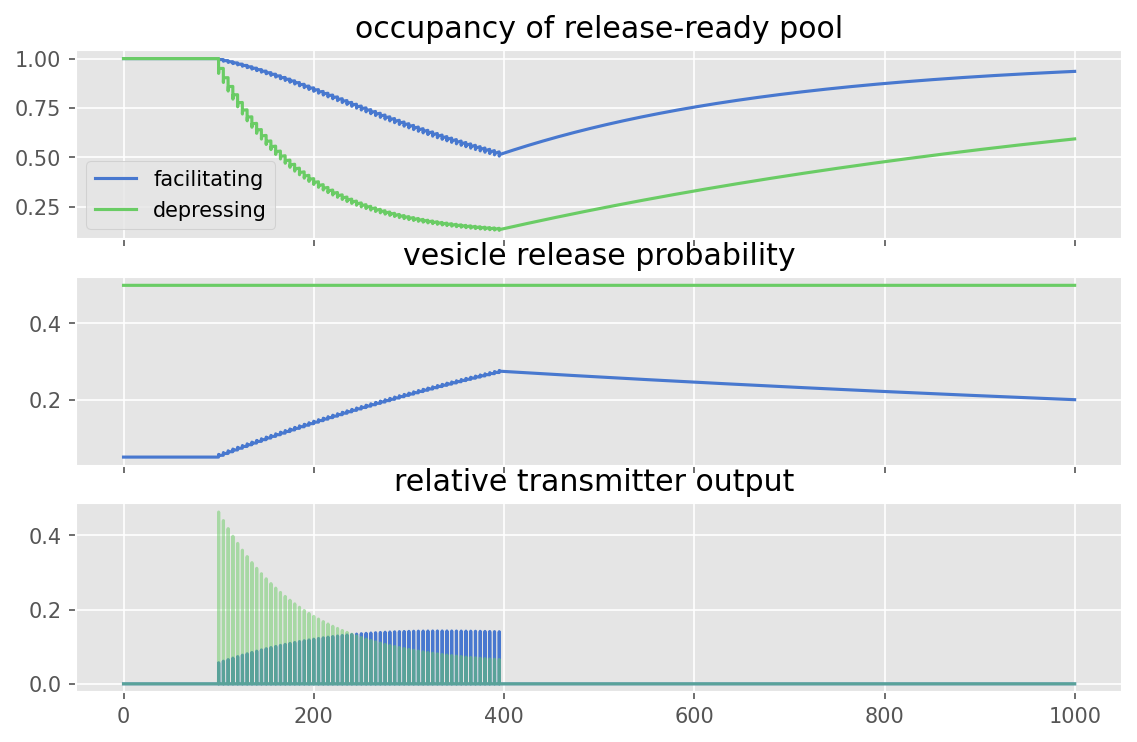

In [25]:
f,axs = subplots(3,1,sharex=True)
axs[0].plot(tv, trajf[:,0],label='facilitating')
axs[0].plot(tv, trajd[:,0],label='depressing')
axs[0].legend()
axs[0].set_title('occupancy of release-ready pool')

axs[1].plot(tv, trajf[:,1],label='facilitating')
axs[1].plot(tv, trajd[:,1],label='depressing')
axs[1].set_title('vesicle release probability')


axs[2].plot(tv, trajf[:,0]*trajf[:,1]*spikes(tv))
axs[2].plot(tv, trajd[:,0]*trajd[:,1]*spikes(tv), alpha=0.5)
axs[2].set_title('relative transmitter output ')


#### Стохастический синапс

In [26]:
class TMProbabilisticPre:
    def __init__(self, spike_process, Nrelease=10, 
                 tau_r=300, tau_f=1500, f=0.05, p0=0.05,
                 tau_t = 0.5, t_quant=3.0):
        self.sites = np.ones(Nrelease)
        self.tau_r = tau_r
        self.tau_f = tau_f
        self.p0 = p0
        self.f = f
        self.p = p0
        self.transmitter = 0
        self.tau_t = tau_t # transmitter tau
        self.t_quant = t_quant
        self.Ns = Nrelease
        self.spikes = spike_process
        self.nq = 0
    def transmitter_conc(self,t):
        return self.transmitter
    def advance(self,t,dt):
        dp = (self.p0-self.p)/self.tau_f
        dtrans = -self.transmitter/self.tau_t
        # release
        self.nq = 0
        if self.spikes(t):
            released = where((self.sites>0)*(np.random.rand(self.Ns)<self.p))[0]
            self.nq = len(released)
            self.sites[released] = 0
            dp += self.f*(1-self.p)
            dtrans += self.nq*self.t_quant
        
        #recovery
        prec = dt/self.tau_r
        recovered = where(np.random.rand(self.Ns)<prec)[0]
        self.sites[recovered] = 1
        
        self.p = self.p + dp*dt         # forward Euler update for release probability
        self.transmitter = self.transmitter + dtrans*dt   # update [Glu] in the cleft
        
        
        

In [27]:
%%time 

#tm_prob = TMProbabilisticPre(spikes)
tv = arange(0,600,h)

fac_kw = dict(tau_r=150,p0=0.01,f=0.1)
dep_kw = dict(tau_r=800,p0=0.5,f=0)

spikes = lambda t,period=15: (t%period == 0)*(t>=100)*(t<500)

Ntrials = 100

trajs = [np.zeros((len(tv),2)) for i in range(Ntrials)]

for ntry in range(Ntrials):
    tm_prob = TMProbabilisticPre(spikes,**fac_kw)
    for i,t in enumerate(tv):
        #trajs[ntry][i] = tm_prob.nq
        tm_prob.advance(t, h)
        trajs[ntry][i] = (tm_prob.nq, tm_prob.transmitter)
        
trajs = array(trajs)

CPU times: user 4.66 s, sys: 85.5 ms, total: 4.74 s
Wall time: 4.67 s


Text(0.5, 1.0, 'Динамика квантов выброса нейромедиатора')

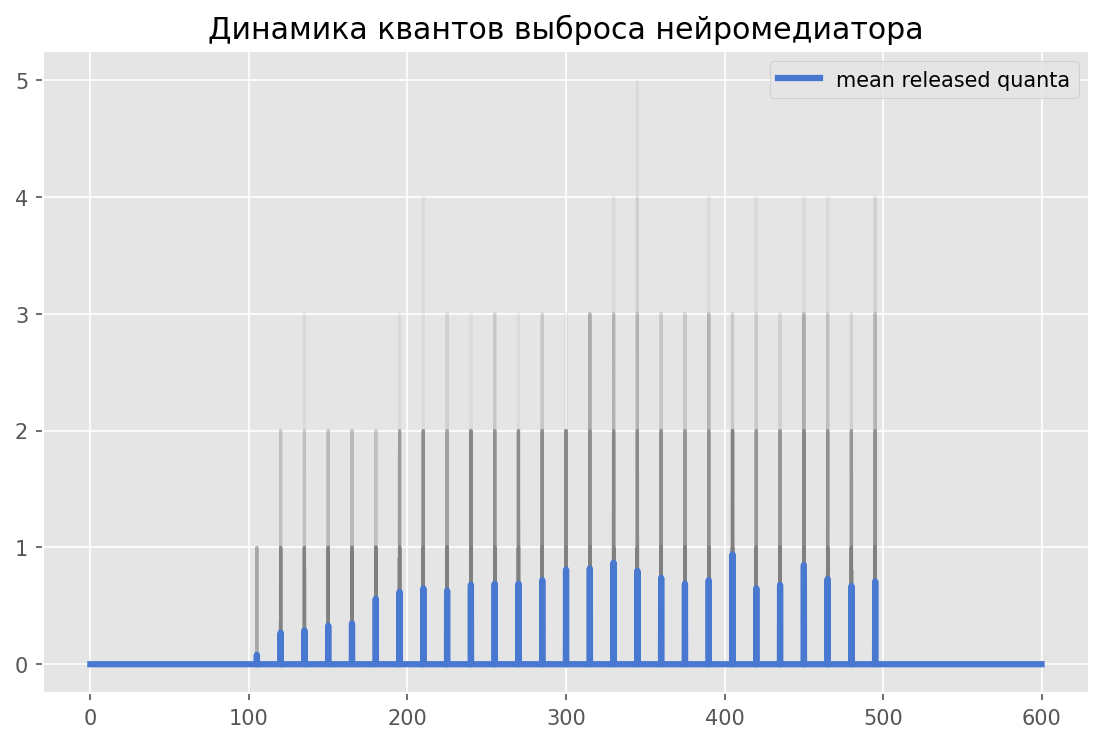

In [28]:
for t in trajs:
    plot(tv, t[:,0], color='gray',alpha=0.1)
plot(tv, np.mean(trajs,0)[:,0],lw=3,label='mean released quanta')
legend()
title('Динамика квантов выброса нейромедиатора')

Text(0.5, 1.0, 'Динамика концентрации глутамата в щели')

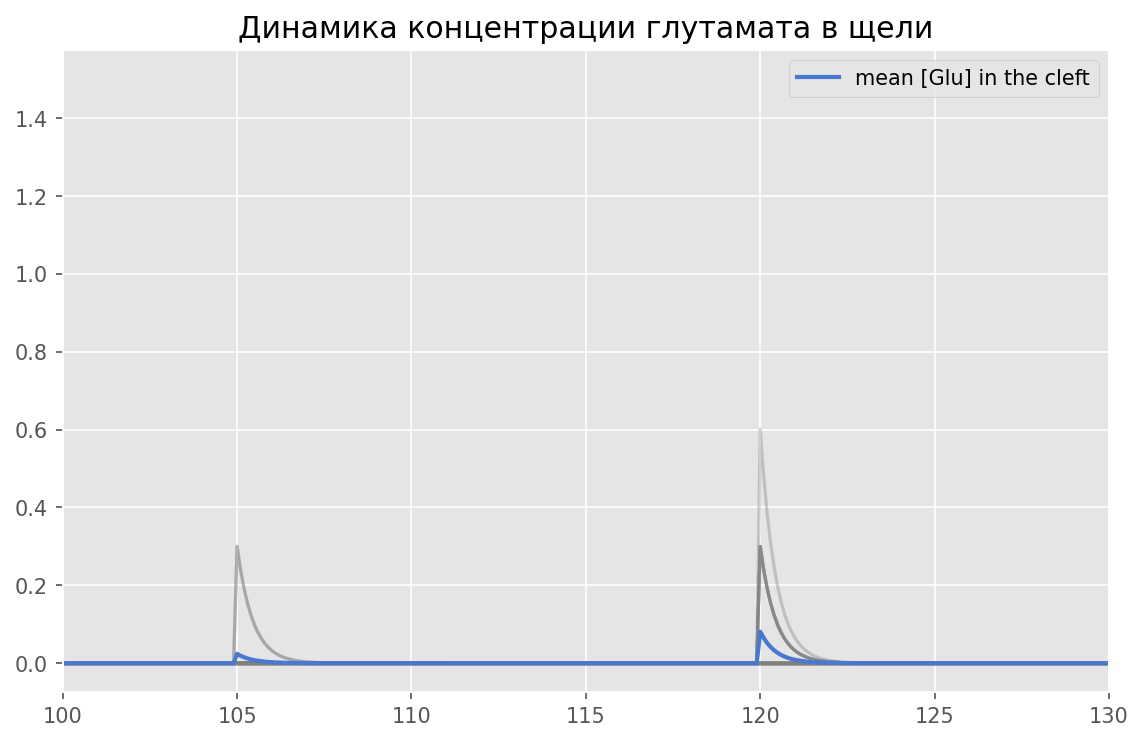

In [29]:
for t in trajs:
    plot(tv, t[:,1], color='gray',alpha=0.1)
plot(tv, np.mean(trajs,0)[:,1],lw=2,label='mean [Glu] in the cleft')
plt.legend()
xlim(100,130)
title('Динамика концентрации глутамата в щели')

##  Связываем пресинаптическую мембрану и постсинаптическую мембрану

In [30]:
tm_prob = TMProbabilisticPre(spikes,**fac_kw)
rx = AMPAR(tm_prob.transmitter_conc)

In [31]:
Vm = -65
h = 0.1

tv = arange(0,600,h)
gsyn = np.zeros_like(tv)
isyn = np.zeros_like(tv)

for i,t in enumerate(tv):
    o,d = rx.advance(t,h)
    tm_prob.advance(t,h)
    gsyn[i] = rx.g
    isyn[i] = rx.isyn(Vm)

Text(0.5, 0, 'время, мс')

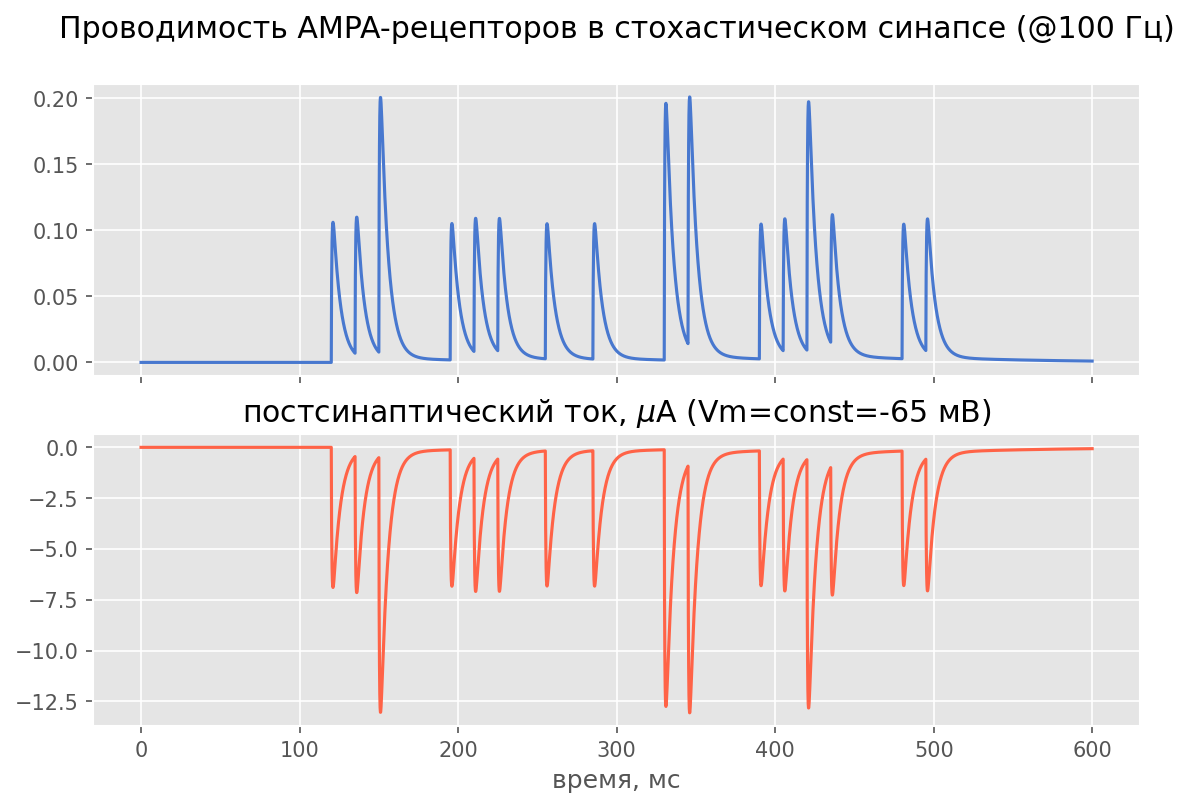

In [32]:
f,axs = subplots(2,1,sharex=True)

axs[0].plot(tv,  gsyn)
axs[0].set_title("Проводимость AMPA-рецепторов в cтохастическом синапсе (@100 Гц)\n")

axs[1].plot(tv,  isyn,color='tomato')
axs[1].set_title("постсинаптический ток, $\mu$A (Vm=const=-65 мВ)")

axs[1].set_xlabel('время, мс')

 - [ ] спонтанный выход медиатора
 - [ ] объединить NMDA и AMPA в один синапс 
 - [ ] Свойства (депр., фас.) ГАМК-ергических синапсов
 - [ ] класс SynapticConnection, объединяющий нейрон1, пресинаптич. процессы, постсинаптич. проводимости и нейрон 2.